<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/stdscaler_smote_rf_8andyear_feat_selected_with_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'american-companies-bankruptcy-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/american-companies-bankruptcy-prediction-dataset


In [3]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = "/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv"

df = pd.read_csv(file_path)

print("Loaded shape:", df.shape)
print("Columns:\n", list(df.columns))
df.head()

Loaded shape: (78682, 21)
Columns:
 ['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [14]:

FEATURES_OLD = ["X8","X17","X3","X11","X10","X1","X6","X15","year"]
# FEATURES = ["X1","X2","X3","X4","X5","X6","X7","X8","X9","X11","X12","X13","X14","X15","X16","X17","X18","year"]
FEATURES = FEATURES_OLD
TARGET   = "status_label"
COMPANY  = "company_name"   # ถ้าไม่มีคอลัมน์นี้ โค้ดจะ fallback อัตโนมัติ


In [15]:

# 0) ตรวจว่าคอลัมน์ครบไหม
missing = [c for c in FEATURES+[TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns: {missing}")

# 1) ฟังก์ชัน normalize label ให้เป็น 0/1 แบบทนทาน
def normalize_status(x):
    if pd.isna(x):
        return np.nan
    t = str(x).strip().lower()
    # ตัวเลขที่มาเป็นสตริง หรือ float 0.0/1.0
    if t in {"0","1"}:
        return int(t)
    try:
        # กรณีเป็น 0.0/1.0 จริง ๆ
        f = float(t)
        if f in (0.0, 1.0):
            return int(f)
    except:
        pass
    # แม็พคำยอดฮิต
    direct = {
        "alive": 0, "non-bankrupt": 0, "nonbankrupt": 0, "healthy": 0, "normal": 0,
        "failed": 1, "fail": 1, "bankrupt": 1, "bankruptcy": 1, "went_bankrupt": 1,
        "yes": 1, "y": 1, "true": 1,
        "no": 0, "n": 0, "false": 0
    }
    if t in direct:
        return direct[t]
    # สุดท้าย ถ้าระบุไม่ถูก ให้คืน NaN เพื่อตรวจสอบ
    return np.nan

y_norm = df[TARGET].apply(normalize_status)

# 2) เช็คค่าที่แปลงไม่ได้ (จะเป็น NaN)
bad_mask = y_norm.isna()
if bad_mask.any():
    print("⚠️ พบ label ที่ไม่รู้จัก (ตัวอย่าง top 20):")
    print(df.loc[bad_mask, TARGET].value_counts().head(20))
    # ทางเลือก: ตัดแถวที่ label ไม่ชัดเจนทิ้งไปก่อน
    df = df.loc[~bad_mask].copy()
    y_norm = y_norm.loc[~bad_mask]

# 3) เขียนกลับเป็นตัวเลข 0/1
df[TARGET] = y_norm.astype(int)

In [16]:
# ==============================
# Load your DataFrame (df)
# ==============================
try:
    df  # noqa: F821
    print("✅ Found existing `df`.")
except NameError:
    import pandas as pd
    print("ℹ️ No existing `df` found. Creating a tiny placeholder. Replace with your CSV load.")
    df = pd.DataFrame({
        "X8":[0.1,0.2,0.3,0.4],
        "X17":[1,2,3,4],
        "X3":[5,6,7,8],
        "X11":[0,1,0,1],
        "X15":[10,11,12,13],
        "X1":[2,3,4,5],
        "X6":[9,8,7,6],
        "status_label":["alive","failed","alive","failed"],
    })
print("df shape:", df.shape)


✅ Found existing `df`.
df shape: (78682, 21)


In [17]:
# ==============================
# Feature selection (X, y) + map target
# ==============================
import numpy as np
import pandas as pd

FEATURES = FEATURES
TARGET   = "status_label"

missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns in df: {missing}")

# Make sure the target column is integer type
df[TARGET] = df[TARGET].astype(int)

X = df[FEATURES].copy()
y = df[TARGET].copy()

print("✅ X,y ready.")
print("X shape:", X.shape, "| y counts:", dict(pd.Series(y).value_counts()))

✅ X,y ready.
X shape: (78682, 9) | y counts: {0: np.int64(73462), 1: np.int64(5220)}


In [18]:
# ==============================
# Imports
# ==============================
!pip -q install imbalanced-learn
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, f1_score,
    precision_score, recall_score, roc_curve, auc
)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import accuracy_score, classification_report

plt.style.use("ggplot")
RANDOM_STATE = 42


In [19]:
# !pip install imbalanced-learn tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, log_loss, accuracy_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# =============================
# PREPARE DATA
# =============================
# Assume df already loaded
X = df[FEATURES].copy()
y = df['status_label'].copy()

# Coerce y to numpy for some metrics that expect array-like
y = np.asarray(y)

# =============================
# DEFINE PIPELINE
# =============================
pipe = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=4, sampling_strategy='auto')),
    ('clf', RandomForestClassifier(
        n_estimators=30,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    ))
])

# =============================
# HELPERS
# =============================
def multiclass_specificity(y_true, y_pred, labels=None):
    """
    Macro-averaged specificity across classes (binary reduces to TN/(TN+FP)).
    """
    if labels is None:
        labels = np.unique(y_true)
    cms = confusion_matrix(y_true, y_pred, labels=labels)
    # If binary cms is 2x2; else kxk. Compute TNR per class (one-vs-rest)
    tnr_list = []
    for i, _ in enumerate(labels):
        # One-vs-rest for class i
        TP = cms[i, i]
        FN = cms[i, :].sum() - TP
        FP = cms[:, i].sum() - TP
        TN = cms.sum() - (TP + FN + FP)
        denom = (TN + FP)
        tnr_list.append(TN / denom if denom > 0 else 0.0)
    return float(np.mean(tnr_list))

def safe_roc_auc(y_true, y_proba, labels=None):
    """
    Binary: use column of positive class (last column by default).
    Multiclass: macro OVR.
    """
    if labels is None:
        labels = np.unique(y_true)
    if len(labels) == 2:
        # Try to find positive class by larger label if numeric; else last column
        pos_idx = 1 if y_proba.shape[1] > 1 else 0
        return roc_auc_score(y_true, y_proba[:, pos_idx])
    else:
        return roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')

# =============================
# STRATIFIED CV WITH PROGRESS BAR
# =============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track per-fold metrics
metrics_rows = []
avg_cm = None

for fold, (train_idx, test_idx) in enumerate(tqdm(skf.split(X, y), total=10, desc="Training SMOTE-RF folds"), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipe.fit(X_train, y_train)

    # Predictions & probabilities
    y_pred = pipe.predict(X_test)
    # Some classifiers might not have predict_proba; RandomForest does.
    y_proba = pipe.predict_proba(X_test)

    # Confusion matrix (aligned to label order)
    labels = np.unique(y)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    if avg_cm is None:
        avg_cm = cm.astype(float)
    else:
        avg_cm += cm.astype(float)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)  # sensitivity
    spec = multiclass_specificity(y_test, y_pred, labels=labels)
    f1m = f1_score(y_test, y_pred, average='macro')
    auc = safe_roc_auc(y_test, y_proba, labels=labels)
    # For log_loss, pass full proba matrix with columns aligned to labels
    # Ensure proba columns correspond to 'labels' order
    clf_classes = pipe.named_steps['clf'].classes_
    # Reindex y_proba columns to match labels order if necessary
    if not np.array_equal(clf_classes, labels):
        # Map columns
        col_map = {c: i for i, c in enumerate(clf_classes)}
        y_proba_aligned = np.column_stack([y_proba[:, col_map[c]] for c in labels])
    else:
        y_proba_aligned = y_proba
    ll = log_loss(y_test, y_proba_aligned, labels=labels)

    metrics_rows.append({
        "fold": fold,
        "Loss (log loss)": ll,
        "Accuracy": acc,
        "Precision": prec,
        "Sensitivity (Recall)": rec,
        "Specificity (TNR)": spec,
        "F1-score": f1m,
        "ROC AUC": auc
    })

    print(f"\n===== Fold {fold} =====")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"Loss (log loss):        {ll:.6f}")
    print(f"Accuracy:               {acc:.6f}")
    print(f"Precision (macro):      {prec:.6f}")
    print(f"Sensitivity (Recall):   {rec:.6f}")
    print(f"Specificity (TNR):      {spec:.6f}")
    print(f"F1-score (macro):       {f1m:.6f}")
    print(f"ROC AUC:                {auc:.6f}")
    print("Confusion Matrix (rows=true, cols=pred, label order={}):".format(list(labels)))
    print(cm)

# =============================
# FINAL SUMMARY
# =============================
print("\n================ FINAL CV SUMMARY ================\n")
df_metrics = pd.DataFrame(metrics_rows).set_index("fold")
summary = df_metrics.agg(['mean', 'std']).T.rename(columns={'mean': 'Mean', 'std': 'Std'})
print(df_metrics.round(6))
print("\n--- Averages (Mean ± Std) ---")
for metric, row in summary.round(6).iterrows():
    print(f"{metric}: {row['Mean']:.6f} ± {row['Std']:.6f}")

# Average confusion matrix across folds
avg_cm /= len(metrics_rows)
print("\n--- Average Confusion Matrix across folds (rows=true, cols=pred) ---")
print(np.round(avg_cm, 2))

# (Optional) If you still want the original F1-only summary:
print("\n================ ORIGINAL F1 SUMMARY ================\n")
print(f"F1 Scores (macro): {np.round(df_metrics['F1-score'].values, 4)}")
print(f"Mean F1: {df_metrics['F1-score'].mean():.4f} ± {df_metrics['F1-score'].std():.4f}")


Training SMOTE-RF folds:  10%|█         | 1/10 [00:14<02:10, 14.45s/it]


===== Fold 1 =====
              precision    recall  f1-score   support

           0     0.9586    0.9029    0.9299     14693
           1     0.2482    0.4511    0.3202      1044

    accuracy                         0.8729     15737
   macro avg     0.6034    0.6770    0.6250     15737
weighted avg     0.9115    0.8729    0.8895     15737

Loss (log loss):        0.319177
Accuracy:               0.872911
Precision (macro):      0.603376
Sensitivity (Recall):   0.677014
Specificity (TNR):      0.677014
F1-score (macro):       0.625047
ROC AUC:                0.815119
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13266  1427]
 [  573   471]]


Training SMOTE-RF folds:  20%|██        | 2/10 [00:29<01:56, 14.57s/it]


===== Fold 2 =====
              precision    recall  f1-score   support

           0     0.9580    0.9042    0.9303     14693
           1     0.2467    0.4416    0.3165      1044

    accuracy                         0.8735     15737
   macro avg     0.6023    0.6729    0.6234     15737
weighted avg     0.9108    0.8735    0.8896     15737

Loss (log loss):        0.328911
Accuracy:               0.873483
Precision (macro):      0.602308
Sensitivity (Recall):   0.672871
Specificity (TNR):      0.672871
F1-score (macro):       0.623401
ROC AUC:                0.806209
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13285  1408]
 [  583   461]]


Training SMOTE-RF folds:  30%|███       | 3/10 [00:43<01:42, 14.61s/it]


===== Fold 3 =====
              precision    recall  f1-score   support

           0     0.9594    0.9028    0.9303     14692
           1     0.2527    0.4626    0.3269      1044

    accuracy                         0.8736     15736
   macro avg     0.6061    0.6827    0.6286     15736
weighted avg     0.9125    0.8736    0.8902     15736

Loss (log loss):        0.321408
Accuracy:               0.873602
Precision (macro):      0.606084
Sensitivity (Recall):   0.682724
Specificity (TNR):      0.682724
F1-score (macro):       0.628578
ROC AUC:                0.813667
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13264  1428]
 [  561   483]]


Training SMOTE-RF folds:  40%|████      | 4/10 [00:59<01:30, 15.02s/it]


===== Fold 4 =====
              precision    recall  f1-score   support

           0     0.9583    0.9039    0.9303     14692
           1     0.2481    0.4464    0.3190      1044

    accuracy                         0.8735     15736
   macro avg     0.6032    0.6751    0.6246     15736
weighted avg     0.9112    0.8735    0.8897     15736

Loss (log loss):        0.326141
Accuracy:               0.873538
Precision (macro):      0.603214
Sensitivity (Recall):   0.675127
Specificity (TNR):      0.675127
F1-score (macro):       0.624629
ROC AUC:                0.811335
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13280  1412]
 [  578   466]]


Training SMOTE-RF folds:  50%|█████     | 5/10 [01:13<01:13, 14.78s/it]


===== Fold 5 =====
              precision    recall  f1-score   support

           0     0.9608    0.9070    0.9331     14692
           1     0.2682    0.4799    0.3441      1044

    accuracy                         0.8786     15736
   macro avg     0.6145    0.6934    0.6386     15736
weighted avg     0.9149    0.8786    0.8940     15736

Loss (log loss):        0.316832
Accuracy:               0.878622
Precision (macro):      0.614523
Sensitivity (Recall):   0.693421
Specificity (TNR):      0.693421
F1-score (macro):       0.638608
ROC AUC:                0.815347
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13325  1367]
 [  543   501]]

================ FINAL CV SUMMARY ================

      Loss (log loss)  Accuracy  Precision  Sensitivity (Recall)  \
fold                                                               
1            0.319177  0.872911   0.603376              0.677014   
2            0.328911  0.873483   0.602308           

In [20]:
# !pip install imbalanced-learn tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, log_loss, accuracy_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# =============================
# PREPARE DATA
# =============================
# Assume df already loaded
X = df[FEATURES].copy()
y = df['status_label'].copy()

# Coerce y to numpy for some metrics that expect array-like
y = np.asarray(y)

# =============================
# DEFINE PIPELINE
# =============================
pipe = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=4, sampling_strategy='auto')),
    ('clf', RandomForestClassifier(
        n_estimators=120,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    ))
])

# =============================
# HELPERS
# =============================
def multiclass_specificity(y_true, y_pred, labels=None):
    """
    Macro-averaged specificity across classes (binary reduces to TN/(TN+FP)).
    """
    if labels is None:
        labels = np.unique(y_true)
    cms = confusion_matrix(y_true, y_pred, labels=labels)
    # If binary cms is 2x2; else kxk. Compute TNR per class (one-vs-rest)
    tnr_list = []
    for i, _ in enumerate(labels):
        # One-vs-rest for class i
        TP = cms[i, i]
        FN = cms[i, :].sum() - TP
        FP = cms[:, i].sum() - TP
        TN = cms.sum() - (TP + FN + FP)
        denom = (TN + FP)
        tnr_list.append(TN / denom if denom > 0 else 0.0)
    return float(np.mean(tnr_list))

def safe_roc_auc(y_true, y_proba, labels=None):
    """
    Binary: use column of positive class (last column by default).
    Multiclass: macro OVR.
    """
    if labels is None:
        labels = np.unique(y_true)
    if len(labels) == 2:
        # Try to find positive class by larger label if numeric; else last column
        pos_idx = 1 if y_proba.shape[1] > 1 else 0
        return roc_auc_score(y_true, y_proba[:, pos_idx])
    else:
        return roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')

# =============================
# STRATIFIED CV WITH PROGRESS BAR
# =============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track per-fold metrics
metrics_rows = []
avg_cm = None

for fold, (train_idx, test_idx) in enumerate(tqdm(skf.split(X, y), total=5, desc="Training SMOTE-RF folds"), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipe.fit(X_train, y_train)

    # Predictions & probabilities
    y_pred = pipe.predict(X_test)
    # Some classifiers might not have predict_proba; RandomForest does.
    y_proba = pipe.predict_proba(X_test)

    # Confusion matrix (aligned to label order)
    labels = np.unique(y)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    if avg_cm is None:
        avg_cm = cm.astype(float)
    else:
        avg_cm += cm.astype(float)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)  # sensitivity
    spec = multiclass_specificity(y_test, y_pred, labels=labels)
    f1m = f1_score(y_test, y_pred, average='macro')
    auc = safe_roc_auc(y_test, y_proba, labels=labels)
    # For log_loss, pass full proba matrix with columns aligned to labels
    # Ensure proba columns correspond to 'labels' order
    clf_classes = pipe.named_steps['clf'].classes_
    # Reindex y_proba columns to match labels order if necessary
    if not np.array_equal(clf_classes, labels):
        # Map columns
        col_map = {c: i for i, c in enumerate(clf_classes)}
        y_proba_aligned = np.column_stack([y_proba[:, col_map[c]] for c in labels])
    else:
        y_proba_aligned = y_proba
    ll = log_loss(y_test, y_proba_aligned, labels=labels)

    metrics_rows.append({
        "fold": fold,
        "Loss (log loss)": ll,
        "Accuracy": acc,
        "Precision": prec,
        "Sensitivity (Recall)": rec,
        "Specificity (TNR)": spec,
        "F1-score": f1m,
        "ROC AUC": auc
    })

    print(f"\n===== Fold {fold} =====")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"Loss (log loss):        {ll:.6f}")
    print(f"Accuracy:               {acc:.6f}")
    print(f"Precision (macro):      {prec:.6f}")
    print(f"Sensitivity (Recall):   {rec:.6f}")
    print(f"Specificity (TNR):      {spec:.6f}")
    print(f"F1-score (macro):       {f1m:.6f}")
    print(f"ROC AUC:                {auc:.6f}")
    print("Confusion Matrix (rows=true, cols=pred, label order={}):".format(list(labels)))
    print(cm)

# =============================
# FINAL SUMMARY
# =============================
print("\n================ FINAL CV SUMMARY ================\n")
df_metrics = pd.DataFrame(metrics_rows).set_index("fold")
summary = df_metrics.agg(['mean', 'std']).T.rename(columns={'mean': 'Mean', 'std': 'Std'})
print(df_metrics.round(6))
print("\n--- Averages (Mean ± Std) ---")
for metric, row in summary.round(6).iterrows():
    print(f"{metric}: {row['Mean']:.6f} ± {row['Std']:.6f}")

# Average confusion matrix across folds
avg_cm /= len(metrics_rows)
print("\n--- Average Confusion Matrix across folds (rows=true, cols=pred) ---")
print(np.round(avg_cm, 2))

# (Optional) If you still want the original F1-only summary:
print("\n================ ORIGINAL F1 SUMMARY ================\n")
print(f"F1 Scores (macro): {np.round(df_metrics['F1-score'].values, 4)}")
print(f"Mean F1: {df_metrics['F1-score'].mean():.4f} ± {df_metrics['F1-score'].std():.4f}")


Training SMOTE-RF folds:  20%|██        | 1/5 [00:57<03:48, 57.03s/it]


===== Fold 1 =====
              precision    recall  f1-score   support

           0     0.9588    0.9081    0.9328     14693
           1     0.2582    0.4502    0.3282      1044

    accuracy                         0.8777     15737
   macro avg     0.6085    0.6792    0.6305     15737
weighted avg     0.9123    0.8777    0.8926     15737

Loss (log loss):        0.308864
Accuracy:               0.877740
Precision (macro):      0.608499
Sensitivity (Recall):   0.679156
Specificity (TNR):      0.679156
F1-score (macro):       0.630482
ROC AUC:                0.824732
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13343  1350]
 [  574   470]]


Training SMOTE-RF folds:  40%|████      | 2/5 [01:57<02:56, 58.96s/it]


===== Fold 2 =====
              precision    recall  f1-score   support

           0     0.9588    0.9083    0.9329     14693
           1     0.2589    0.4511    0.3290      1044

    accuracy                         0.8779     15737
   macro avg     0.6089    0.6797    0.6309     15737
weighted avg     0.9124    0.8779    0.8928     15737

Loss (log loss):        0.313454
Accuracy:               0.877931
Precision (macro):      0.608882
Sensitivity (Recall):   0.679703
Specificity (TNR):      0.679703
F1-score (macro):       0.630942
ROC AUC:                0.813137
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13345  1348]
 [  573   471]]


Training SMOTE-RF folds:  60%|██████    | 3/5 [02:56<01:57, 58.91s/it]


===== Fold 3 =====
              precision    recall  f1-score   support

           0     0.9601    0.9108    0.9348     14692
           1     0.2713    0.4674    0.3433      1044

    accuracy                         0.8814     15736
   macro avg     0.6157    0.6891    0.6390     15736
weighted avg     0.9144    0.8814    0.8955     15736

Loss (log loss):        0.305310
Accuracy:               0.881355
Precision (macro):      0.615684
Sensitivity (Recall):   0.689100
Specificity (TNR):      0.689100
F1-score (macro):       0.639043
ROC AUC:                0.823661
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13381  1311]
 [  556   488]]


Training SMOTE-RF folds:  80%|████████  | 4/5 [03:54<00:58, 58.80s/it]


===== Fold 4 =====
              precision    recall  f1-score   support

           0     0.9596    0.9107    0.9345     14692
           1     0.2683    0.4607    0.3391      1044

    accuracy                         0.8808     15736
   macro avg     0.6139    0.6857    0.6368     15736
weighted avg     0.9138    0.8808    0.8950     15736

Loss (log loss):        0.309730
Accuracy:               0.880846
Precision (macro):      0.613943
Sensitivity (Recall):   0.685714
Specificity (TNR):      0.685714
F1-score (macro):       0.636806
ROC AUC:                0.822594
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13380  1312]
 [  563   481]]


Training SMOTE-RF folds: 100%|██████████| 5/5 [04:51<00:00, 58.38s/it]


===== Fold 5 =====
              precision    recall  f1-score   support

           0     0.9609    0.9117    0.9357     14692
           1     0.2778    0.4780    0.3514      1044

    accuracy                         0.8829     15736
   macro avg     0.6194    0.6948    0.6435     15736
weighted avg     0.9156    0.8829    0.8969     15736

Loss (log loss):        0.308344
Accuracy:               0.882944
Precision (macro):      0.619372
Sensitivity (Recall):   0.694845
Specificity (TNR):      0.694845
F1-score (macro):       0.643537
ROC AUC:                0.822363
Confusion Matrix (rows=true, cols=pred, label order=[np.int64(0), np.int64(1)]):
[[13395  1297]
 [  545   499]]

================ FINAL CV SUMMARY ================

      Loss (log loss)  Accuracy  Precision  Sensitivity (Recall)  \
fold                                                               
1            0.308864  0.877740   0.608499              0.679156   
2            0.313454  0.877931   0.608882           

In [21]:
f1_scores

[]

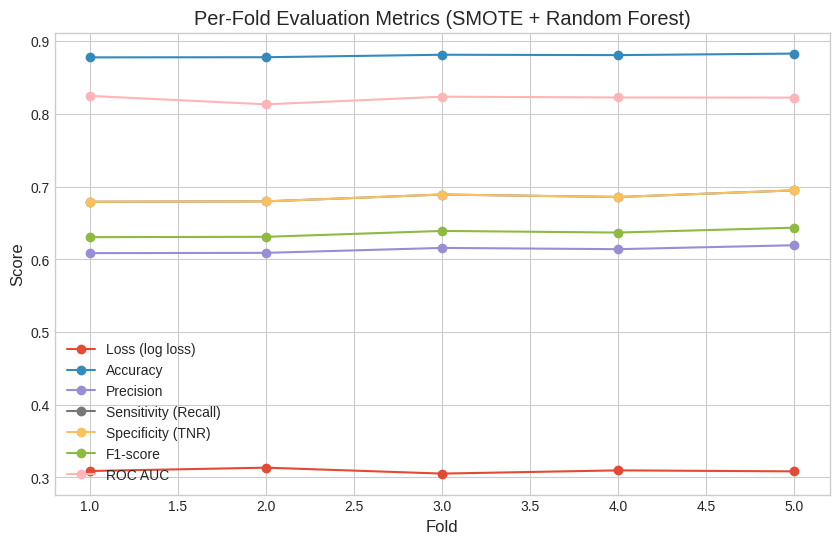

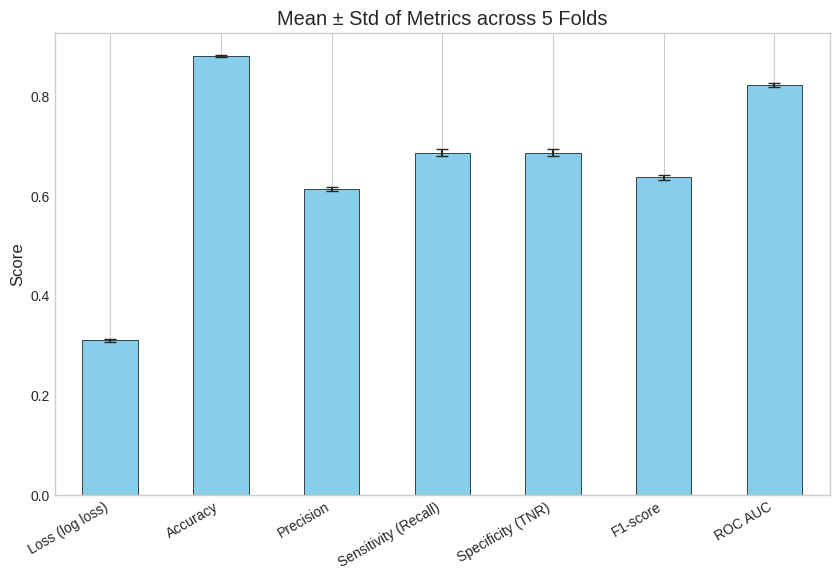

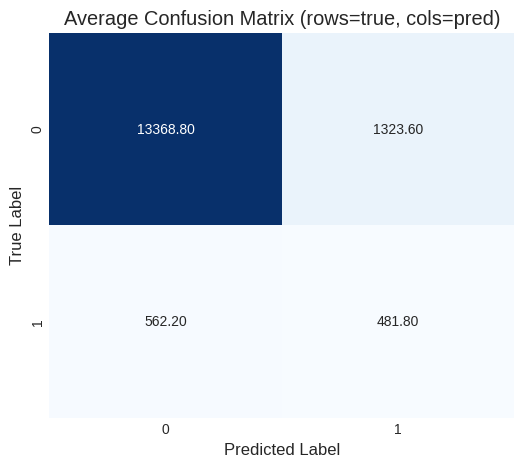

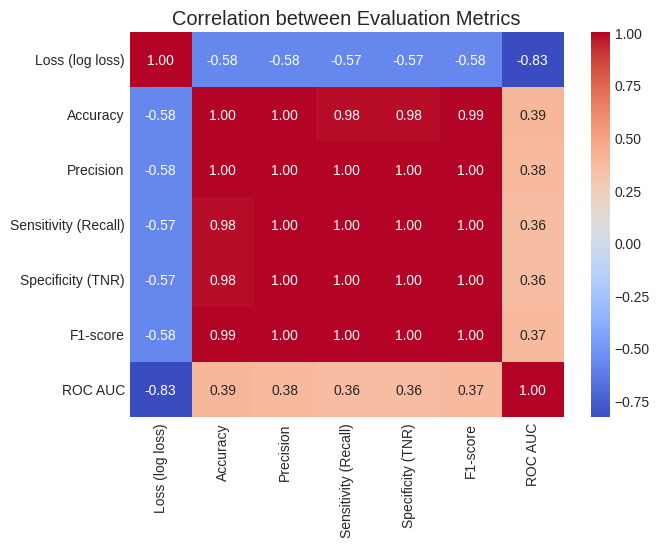

In [22]:
# =============================
# 📊 PLOTS FOR ALL EVALUATIONS
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# --- 1️⃣ Line Plot: per-fold metrics ---
plt.figure(figsize=(10, 6))
for col in df_metrics.columns:
    if col != "fold":
        plt.plot(df_metrics.index, df_metrics[col], marker='o', label=col)
plt.title("Per-Fold Evaluation Metrics (SMOTE + Random Forest)")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# --- 2️⃣ Bar Plot: mean ± std summary ---
summary_plot = df_metrics.agg(['mean', 'std']).T
summary_plot['mean'].plot.bar(
    yerr=summary_plot['std'],
    capsize=4,
    figsize=(10, 6),
    color='skyblue',
    edgecolor='black'
)
plt.title("Mean ± Std of Metrics across 5 Folds")
plt.ylabel("Score")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.show()

# --- 3️⃣ Confusion Matrix (average across folds) ---
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Average Confusion Matrix (rows=true, cols=pred)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- 4️⃣ Correlation Heatmap between metrics ---
plt.figure(figsize=(7, 5))
sns.heatmap(df_metrics.drop(columns=["fold"], errors="ignore").corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between Evaluation Metrics")
plt.show()
